In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Cause plots to be displayed in the notebook:
%pylab inline
%matplotlib inline

# Override default figure sizing:
#pylab.rcParams['figure.figsize'] = (10, 6)
sns.set(color_codes = True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
missing_values=["n/a","na","--","?"]
df=pd.read_csv('../../dataproject/train.csv', na_values=missing_values)

In [3]:
df['date']=pd.to_datetime(df['date'])

In [4]:
df_store1 =df[(df['store']==1)&(df['item']==1)]
#df_store1

In [5]:
timeseries_columns = ['date','sales']
ts_store1=df_store1[timeseries_columns]
ts_store1=ts_store1.set_index('date')
#ts_store1

Text(0, 0.5, 'sales')

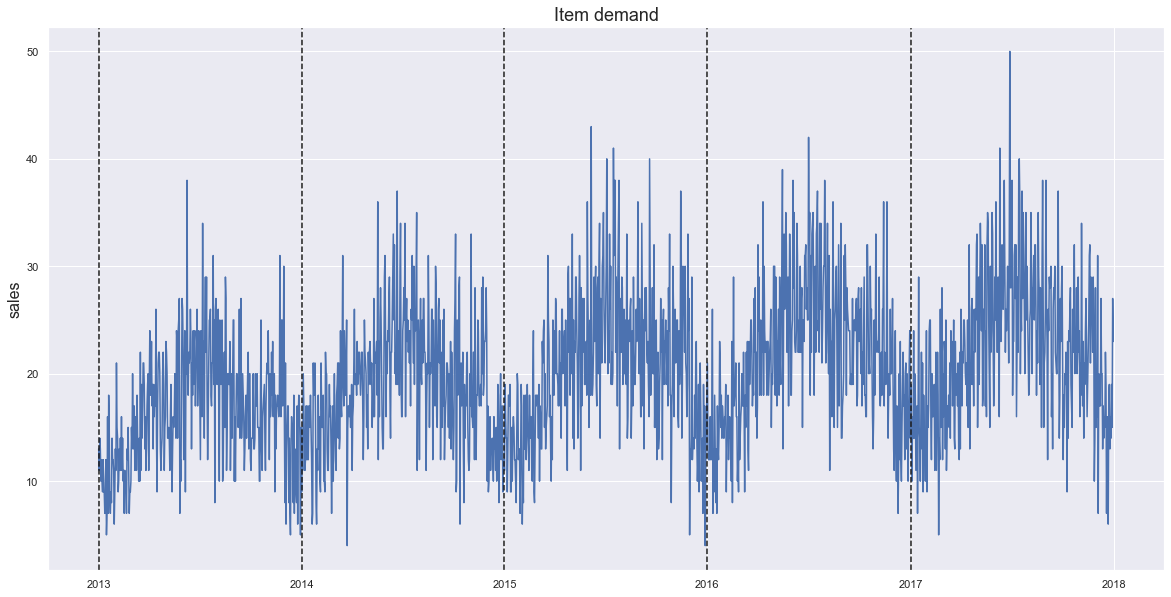

In [13]:
plt.figure(figsize = (20,10))
plt.plot(ts_store1)
for year in range(2013,2018):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')
plt.title('Item demand', fontsize = 18)
plt.ylabel('sales', fontsize = 16)

In [6]:
train = ts_store1.iloc[:len(ts_store1)-92] 
test = ts_store1.iloc[len(ts_store1)-92:] # set 3 months(92 days)) for testing

### Checking Stationary

### Dickey-Fuller Test

The Dickey-Fuller test is a type of hypothesis testing to determine whether the df is either stationary or non-stationary. <br>
- If the p_value is less than 0.5, reject the null hypothesis and the df is stationary.
- If the p_value is more than 0.5, accept the null hypothesis and the df is non-stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.936551
p-value: 0.041260
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [9]:
tsdiff=ts_store1.diff().dropna(inplace = False)

In [8]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_store1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tsdiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.676794
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


as p < 0.05 (0.04) the null hypothesis is rejected. Therefore can be said data is stationary d=0

### ARIMA Model

A:Auto. R:Regressive. I:Integrated. M:Moving. A:Average.
                    p: The number of lag observations included in the model, also called the lag order
d: The number of times that the raw observations are differenced, also called the degree of differencing. how many diff d=>0
q: Window size for moving average

#### Autocorrelation and Partial Autocorrelation

Autocorrelation: is used to find repetitive patterns or periodic signal in time series.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 0, 'Lag (Days)')

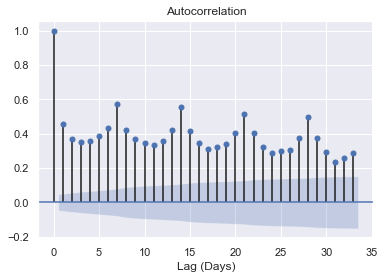

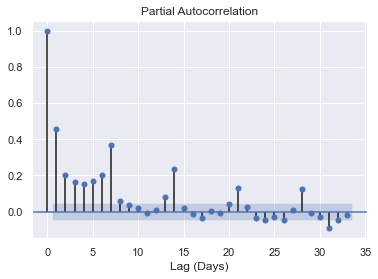

In [9]:
# Plotting autocorrelation function
plot_acf(train)
plt.xlabel('Lag (Days)')
plot_pacf(train)
plt.xlabel('Lag (Days)')

Text(0.5, 0, 'Lag (Days)')

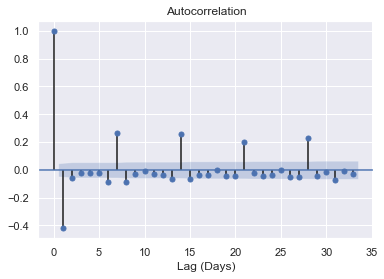

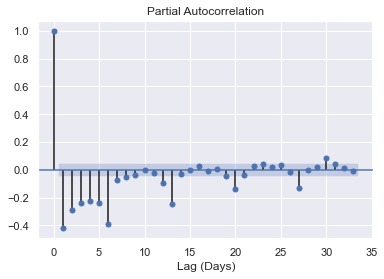

In [12]:
# Plotting autocorrelation function with one differencing
plot_acf(train.diff().dropna(inplace = False))
plt.xlabel('Lag (Days)')
plot_pacf(train.diff().dropna(inplace = False))
plt.xlabel('Lag (Days)')

from the ACF and PCF, the best guess for ARIMA will be (1,0,0) 

#### Determine best parameter based on smallest AIC

In [43]:
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [54]:
#Create empty list to store search results
order_aic=[]
# Loop over p values
for p in range(3):
    for q in range(3):
        model=ARIMA(train, order=(p,1,q))
        results=model.fit()
        #Append order and results tuple
        order_aic.append((p,q,results.aic, results.bic))   

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

In [55]:
order_df = pd.DataFrame(order_aic,columns=['p','q','AIC','BIC'])
print(order_df.sort_values('AIC'))

   p  q           AIC           BIC
8  2  2  10717.984575  10750.730231
7  2  1  10748.112006  10775.400053
5  1  2  10753.578295  10780.866342
2  0  2  10755.864195  10777.694633
4  1  1  10757.248147  10779.078584
1  0  1  10763.372628  10779.745456
6  2  0  11210.755571  11232.586008
3  1  0  11362.493265  11378.866093
0  0  0  11699.312010  11710.227229


In [46]:
#Create empty list to store search results
order_aic=[]
# Loop over p values
for p in range(7):
    for q in range(7):
        model=ARIMA(train, order=(p,1,q))
        results=model.fit()
        #Append order and results tuple
        order_aic.append((p,q,results.aic, results.bic))      


C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimiz

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian fail

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


LinAlgError: SVD did not converge

In [47]:
order_df = pd.DataFrame(order_aic,columns=['p','q','AIC','BIC'])
print(order_df.sort_values('AIC'))

    p  q           AIC           BIC
41  5  6  10379.594598  10450.543518
34  4  6  10397.020783  10462.512094
40  5  5  10397.449022  10462.940333
33  4  5  10440.085469  10500.119171
38  5  3  10490.471936  10545.048029
39  5  4  10490.823475  10550.857177
20  2  6  10491.349030  10545.925123
32  4  4  10495.710832  10550.286925
18  2  4  10496.430717  10540.091592
24  3  3  10496.991787  10540.652661
17  2  3  10498.808871  10537.012137
27  3  6  10506.577794  10566.611496
26  3  5  10509.824181  10564.400274
25  3  4  10523.617103  10572.735586
46  6  4  10584.699364  10650.190675
45  6  3  10585.289605  10645.323307
44  6  2  10628.173398  10682.749491
43  6  1  10631.197409  10680.315893
42  6  0  10642.059458  10685.720332
37  5  2  10687.866259  10736.984743
36  5  1  10688.700337  10732.361211
30  4  2  10699.370731  10743.031605
31  4  3  10701.821061  10750.939544
23  3  2  10709.375865  10747.579130
29  4  1  10709.503117  10747.706382
19  2  5  10715.750910  10764.869393
6

In [18]:
arima_model = ARIMA(train, (1,0,0), freq = 'D').fit()

In [37]:
arima_model_gs = ARIMA(train, (6,1,1), freq = 'D').fit()

In [23]:
arima_model_2 = ARIMA(train, (4,1,1), freq = 'D').fit()

In [51]:
# from grid search
arima_model_3 = ARIMA(train, (5,1,6), freq = 'D').fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [20]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1734
Model:                     ARMA(1, 0)   Log Likelihood               -5577.006
Method:                       css-mle   S.D. of innovations              6.033
Date:                Sat, 20 Feb 2021   AIC                          11160.011
Time:                        15:34:39   BIC                          11176.386
Sample:                    01-01-2013   HQIC                         11166.067
                         - 09-30-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          19.9594      0.267     74.777      0.000      19.436      20.483
ar.L1.sales     0.4575      0.021     21.410      0.000       0.416       0.499
                                    Roots       

In [71]:
#print(arima_model_gs.summary())

In [70]:
#print(arima_model_2.summary())

In [52]:
print(arima_model_3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(5, 1, 6)   Log Likelihood               -5176.797
Method:                       css-mle   S.D. of innovations              4.776
Date:                Wed, 24 Feb 2021   AIC                          10379.595
Time:                        19:21:15   BIC                          10450.544
Sample:                    01-02-2013   HQIC                         10405.835
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0077      0.011      0.672      0.502      -0.015       0.030
ar.L1.D.sales    -0.1943        nan        nan        nan         nan         nan
ar.L2.D.sales    -0.6455      0.000  -23

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\monic\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


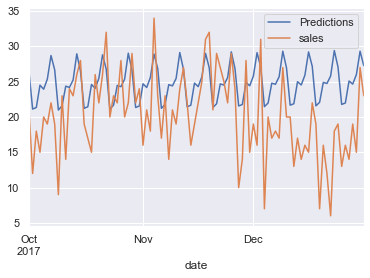

In [87]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictionsarima = arima_model_3.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictionsarima.plot(legend = True) 
test['sales'].plot(legend = True)

In [58]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))
    print('RMSE: {}'.format(sqrt(mean_squared_error(y_true, y_pred))))

In [88]:
print('ARIMA')
regPrintErr(test['sales'], predictionsarima)

ARIMA
R2 Score: -0.45196348471557335
MAPE: 36.155410045391235
RMSE: 7.017389839237427


In [ ]:
### Walk-Forward Validation

In [79]:
train = train['sales']
test = test['sales']
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,2)) 
    model_fit = model.fit()
    #Array containing the forecast value, the standard error of the forecast, and the confidence interval information.
    #Only interested in the 1st element
    yhat = model_fit.forecast()[0] #Forecasting the next step
    predictions.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)

In [80]:
test

date
2017-10-01    21
2017-10-02    12
2017-10-03    18
2017-10-04    15
2017-10-05    20
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 92, dtype: int64

In [81]:
predictions

[array([24.49202895]),
 array([23.05727017]),
 array([22.37641495]),
 array([23.94873891]),
 array([23.15256092]),
 array([23.54442033]),
 array([22.58849533]),
 array([22.43917445]),
 array([21.34617544]),
 array([19.59157893]),
 array([21.85960048]),
 array([19.50786225]),
 array([20.8424298]),
 array([19.9181047]),
 array([20.10344288]),
 array([20.27227094]),
 array([19.04101724]),
 array([19.55410465]),
 array([19.82335372]),
 array([21.75895481]),
 array([20.63970835]),
 array([21.28413345]),
 array([22.085195]),
 array([20.21805284]),
 array([21.60775868]),
 array([21.87121311]),
 array([23.10595592]),
 array([21.87551241]),
 array([22.72501502]),
 array([23.90267303]),
 array([22.61978364]),
 array([23.31686153]),
 array([22.26964116]),
 array([23.46444183]),
 array([22.78280645]),
 array([24.99945627]),
 array([22.39397849]),
 array([21.8497643]),
 array([23.21597813]),
 array([21.71715949]),
 array([23.01025172]),
 array([22.21352122]),
 array([22.64202181]),
 array([22.53373

In [82]:
a = pd.DataFrame(test)
b = pd.DataFrame(predictions)
b.set_index(test.index, inplace = True)
compare = pd.concat([a,b],axis = 1)
compare.columns = ['Actual', 'Predict']
compare.head()

,Actual,Predict
date,,
2017-10-01,21,24.492029
2017-10-02,12,23.057270
2017-10-03,18,22.376415
2017-10-04,15,23.948739
2017-10-05,20,23.152561


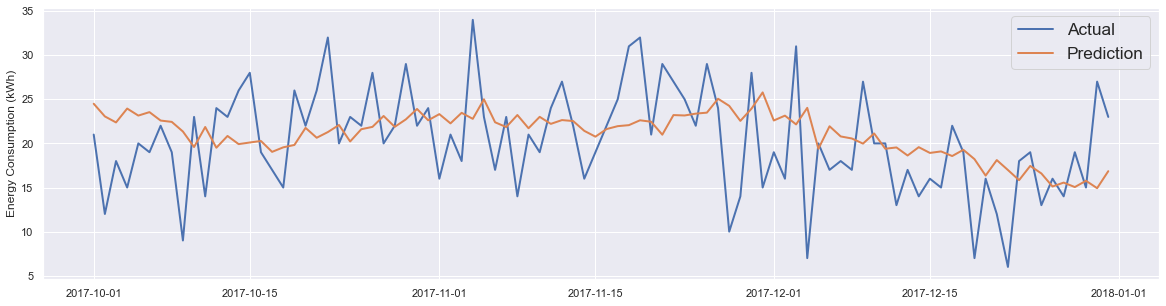

In [83]:
plt.figure(figsize = (20,5))
plt.plot(compare['Actual'], label = 'Actual', linewidth = 2)
plt.plot(compare['Predict'], label = 'Prediction', linewidth = 2)
plt.ylabel('Energy Consumption (kWh)')
plt.legend(fontsize = 'x-large')

In [84]:
print('ARIMA -Walk_Forward')
regPrintErr(compare['Actual'], compare['Predict'])

ARIMA -Walk_Forward
R2 Score: -0.02347667351667737
MAPE: 27.11743693692079
RMSE: 5.891647174597388


In [101]:
results = {'Actual':test.sales, 'ARIMA':predictionsarima}

In [97]:
predictionsarima

2017-10-01    26.421687
2017-10-02    21.120660
2017-10-03    21.342084
2017-10-04    24.506238
2017-10-05    23.933197
                ...    
2017-12-27    25.094284
2017-12-28    24.656710
2017-12-29    26.013510
2017-12-30    29.311990
2017-12-31    27.280752
Freq: D, Name: Predictions, Length: 92, dtype: float64

In [100]:
test.sales

date
2017-10-01    21
2017-10-02    12
2017-10-03    18
2017-10-04    15
2017-10-05    20
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 92, dtype: int64

In [102]:
results_arima=pd.DataFrame(results)

In [103]:
results_arima.head()

,Actual,ARIMA
2017-10-01,21,26.421687
2017-10-02,12,21.120660
2017-10-03,18,21.342084
2017-10-04,15,24.506238
2017-10-05,20,23.933197


In [104]:
results_arima.to_csv('results_ARIMA.csv')